<a href="https://colab.research.google.com/github/tomasz-soltysiak/Fraud_transaction/blob/master/Fraud_dedection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import matplotlib.patches as mpatches
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import RobustScaler, StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score,roc_curve,confusion_matrix,roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC



/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


After adding libraries, I upload data.

In [7]:
df=pd.read_csv('/content/drive/My Drive/Data Science/ML fraud detection/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [8]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
Time      284807 non-null float64
V1        284807 non-null float64
V2        284807 non-null float64
V3        284807 non-null float64
V4        284807 non-null float64
V5        284807 non-null float64
V6        284807 non-null float64
V7        284807 non-null float64
V8        284807 non-null float64
V9        284807 non-null float64
V10       284807 non-null float64
V11       284807 non-null float64
V12       284807 non-null float64
V13       284807 non-null float64
V14       284807 non-null float64
V15       284807 non-null float64
V16       284807 non-null float64
V17       284807 non-null float64
V18       284807 non-null float64
V19       284807 non-null float64
V20       284807 non-null float64
V21       284807 non-null float64
V22       284807 non-null float64
V23       284807 non-null float64
V24       284807 non-null float64
V25       284807 non-null float64
V26  

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [9]:
df=df.dropna(axis=0)
df.isnull().sum(axis=0)

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

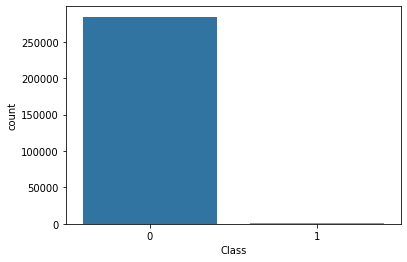

In [10]:
sns.countplot(df['Class'])


In [11]:
pd.Series(df['Class']).value_counts()

0    284315
1       492
Name: Class, dtype: int64

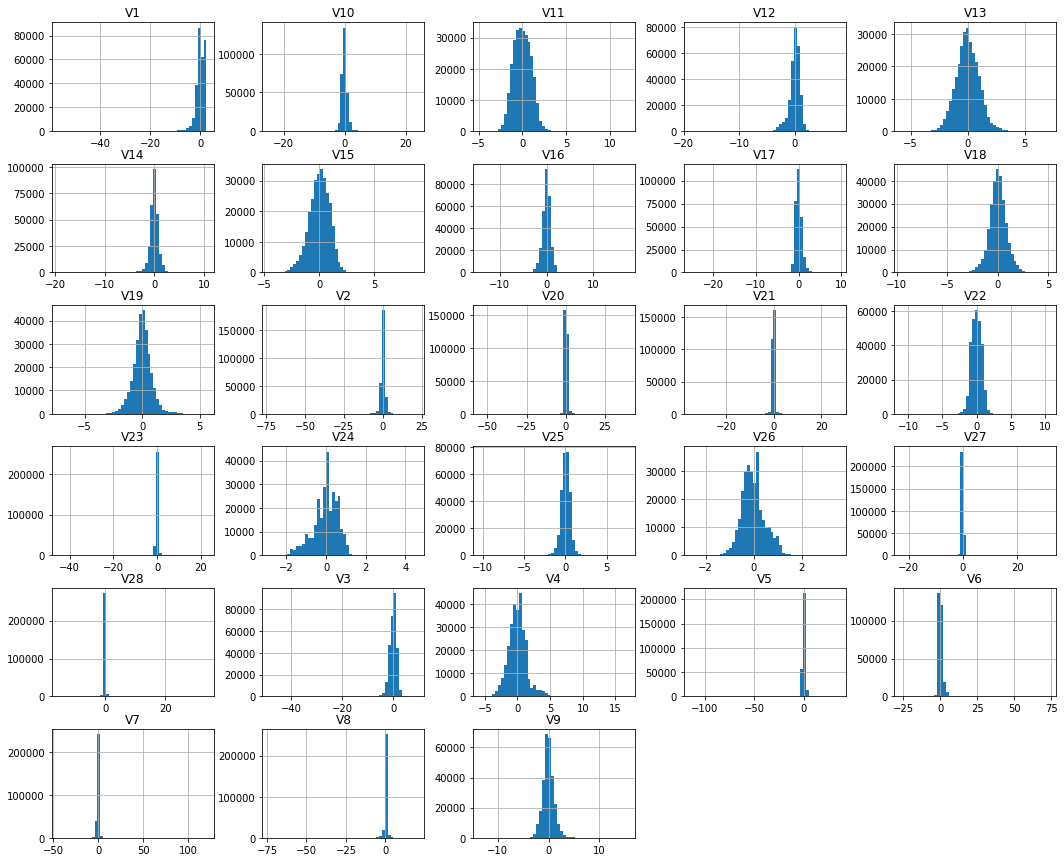

In [12]:
plot = df.drop(["Class", "Amount", "Time"], axis=1).hist(bins=50,
                                                         figsize=(18, 15));

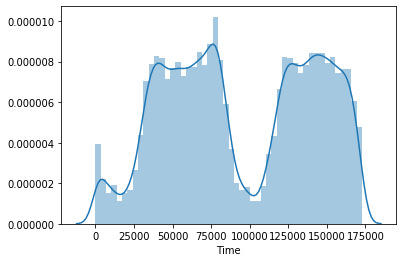

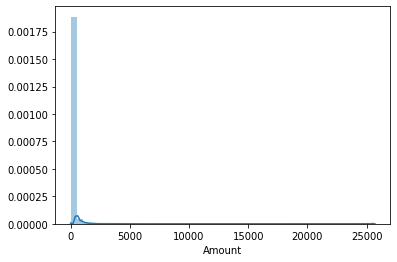

In [13]:
plt.figure()
sns.distplot(df['Time'])
plt.figure()
sns.distplot(df['Amount'])


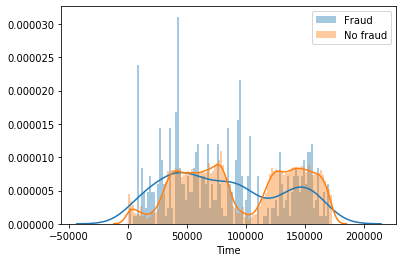

In [14]:
df_fraud=df[df['Class']==1]
df_nofraud=df[df['Class']==0]
sns.distplot(df_fraud['Time'],bins=100)
sns.distplot(df_nofraud['Time'],bins=100)
plt.legend(labels=['Fraud','No fraud'])

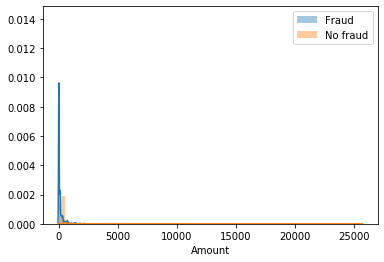

In [15]:
sns.distplot(df_fraud['Amount'])
sns.distplot(df_nofraud['Amount'])
plt.legend(labels=['Fraud','No fraud'])

Przybliżenie wykresu

(-100, 1500)

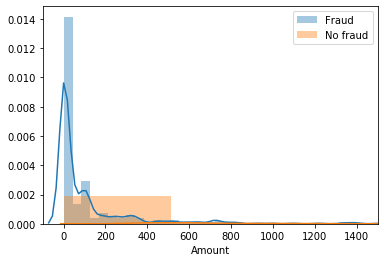

In [16]:
sns.distplot(df_fraud['Amount'])
sns.distplot(df_nofraud['Amount'])
plt.legend(labels=['Fraud','No fraud'])
plt.xlim(-100,1500)

Logarytmowanie kolumny "Amount"

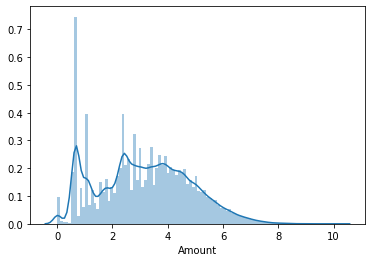

In [17]:
sns.distplot(np.log1p(df["Amount"]), bins=100)

Następnie podział na Fraud/No Fraud

(-1, 8.5)

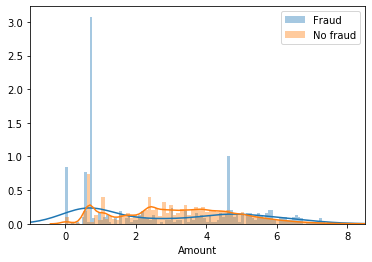

In [18]:
sns.distplot(np.log1p(df[df['Class']==1]["Amount"]), bins=100)
sns.distplot(np.log1p(df[df['Class']==0]["Amount"]), bins=100)
plt.legend(labels=['Fraud','No fraud'])
plt.xlim(-1,8.5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Legend does not support 'F' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Legend does not support 'r' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Legend does not support 'a' instances.
A proxy artist may be used instead.
See: http://matplotlib.org/users/legend_guide.html#creating-artists-specifically-for-adding-to-the-legend-aka-proxy-artists
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: Legend does not sup

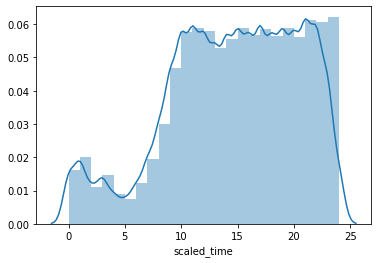

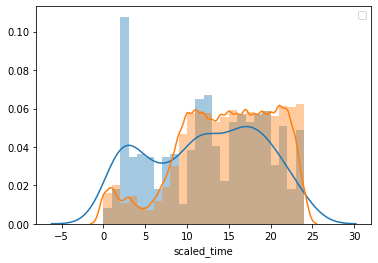

In [19]:
np.floor((172792/3600)%24)
np.floor((89000/3600)%24)

df['scaled_time']=round((df['Time']/3600)%24)
df_fraud=df[df['Class']==1]
df_nofraud=df[df['Class']==0]
df.head()
sns.distplot(df['scaled_time'], bins=24)
plt.figure()
sns.distplot(df_fraud['scaled_time'], bins=24)
sns.distplot(df_nofraud['scaled_time'], bins=24)
plt.legend('Fraud', 'No Fraud')

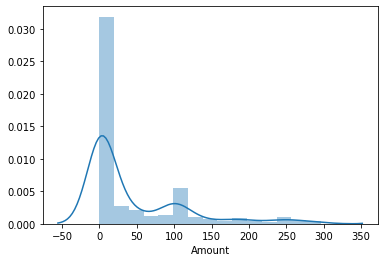

In [20]:

sns.distplot(df_fraud[df_fraud['Amount']<300]['Amount'])

In [21]:
df_fraud.info()
df_fraud.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 492 entries, 541 to 281674
Data columns (total 32 columns):
Time           492 non-null float64
V1             492 non-null float64
V2             492 non-null float64
V3             492 non-null float64
V4             492 non-null float64
V5             492 non-null float64
V6             492 non-null float64
V7             492 non-null float64
V8             492 non-null float64
V9             492 non-null float64
V10            492 non-null float64
V11            492 non-null float64
V12            492 non-null float64
V13            492 non-null float64
V14            492 non-null float64
V15            492 non-null float64
V16            492 non-null float64
V17            492 non-null float64
V18            492 non-null float64
V19            492 non-null float64
V20            492 non-null float64
V21            492 non-null float64
V22            492 non-null float64
V23            492 non-null float64
V24            492 non-nul

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_time
count,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.000000,492.0,492.000000
mean,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,-5.676883,3.800173,-6.259393,-0.109334,-6.971723,-0.092929,-4.139946,-6.665836,-2.246308,0.680659,0.372319,0.713588,0.014049,-0.040308,-0.105130,0.041449,0.051648,0.170575,0.075667,122.211321,1.0,12.111789
std,47835.365138,6.783687,4.291216,7.110937,2.873318,5.372468,1.858124,7.206773,6.797831,2.500896,4.897341,2.678605,4.654458,1.104518,4.278940,1.049915,3.865035,6.970618,2.899366,1.539853,1.346635,3.869304,1.494602,1.579642,0.515577,0.797205,0.471679,1.376766,0.547291,256.683288,0.0,6.754474
min,406.000000,-30.552380,-8.402154,-31.103685,-1.313275,-22.105532,-6.406267,-43.557242,-41.044261,-13.434066,-24.588262,-1.702228,-18.683715,-3.127795,-19.214325,-4.498945,-14.129855,-25.162799,-9.498746,-3.681904,-4.128186,-22.797604,-8.887017,-19.254328,-2.028024,-4.781606,-1.152671,-7.263482,-1.869290,0.000000,1.0,0.000000
25%,41241.500000,-6.036063,1.188226,-8.643489,2.373050,-4.792835,-2.501511,-7.965295,-0.195336,-3.872383,-7.756698,1.973397,-8.688177,-0.979117,-9.692723,-0.643539,-6.562915,-11.945057,-4.664576,-0.299423,-0.171760,0.041787,-0.533764,-0.342175,-0.436809,-0.314348,-0.259416,-0.020025,-0.108868,1.000000,1.0,6.000000
50%,75568.500000,-2.342497,2.717869,-5.075257,4.177147,-1.522962,-1.424616,-3.034402,0.621508,-2.208768,-4.578825,3.586218,-5.502530,-0.065566,-6.729720,-0.057227,-3.549795,-5.302949,-1.664346,0.646807,0.284693,0.592146,0.048434,-0.073135,-0.060795,0.088371,0.004321,0.394926,0.146344,9.250000,1.0,12.000000
75%,128483.000000,-0.419200,4.971257,-2.276185,6.348729,0.214562,-0.413216,-0.945954,1.764879,-0.787850,-2.614184,5.307078,-2.974088,0.672964,-4.282821,0.609189,-1.226043,-1.341940,0.091772,1.649318,0.822445,1.244611,0.617474,0.308378,0.285328,0.456515,0.396733,0.826029,0.381152,105.890000,1.0,18.000000
max,170348.000000,2.132386,22.057729,2.250210,12.114672,11.095089,6.474115,5.802537,20.007208,3.353525,4.031435,12.018913,1.375941,2.815440,3.442422,2.471358,3.139656,6.739384,3.790316,5.228342,11.059004,27.202839,8.361985,5.466230,1.091435,2.208209,2.745261,3.052358,1.779364,2125.870000,1.0,24.000000


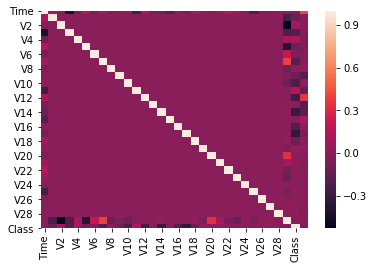

In [22]:
sns.heatmap(df.corr())

In [23]:
Rob_scaler=RobustScaler()

df['scaled_Amount']=Rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,scaled_time,scaled_Amount
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,0.0,1.783274
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,0.0,-0.269825
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,0.0,4.983721
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,0.0,1.418291
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,0.0,0.670579


In [24]:
df['scaled_Amount'].describe()

count    284807.000000
mean          0.927124
std           3.495006
min          -0.307413
25%          -0.229162
50%           0.000000
75%           0.770838
max         358.683155
Name: scaled_Amount, dtype: float64

Jakub: Jak widać mamy niezbalansowane dane. Jest w sumie 284315 rekordów oznaczonych jako nie fraudy oraz 492 fraudów. Sposobem na poradzenie sobie z tym problemem jest są metody zwane Oversampling oraz Undersampling. Jak w przypadku Undersamplingu nie ma problemu jeśli chodzi o wiarygodność danych, tak w Oversamplingu jest trochę inaczej, ponieważ sztucznie dodajemy na podstawie pewnych funckji. To może spowodować że nasz model w przypadku nowej testowej bazy danych będzie mniej skuteczny. Dlatego nasz projekt będzie uwzględniał trzy metody Undersampling, Oversampling oraz Oversampling z wykorzystaniem SMOTE.

In [0]:
pca_list = list(df.columns.values)
pca_list.remove('Time')
pca_list.remove('Amount')
pca_list.remove('Class')
pca_list.remove('scaled_time')
pca_list.remove('scaled_Amount')

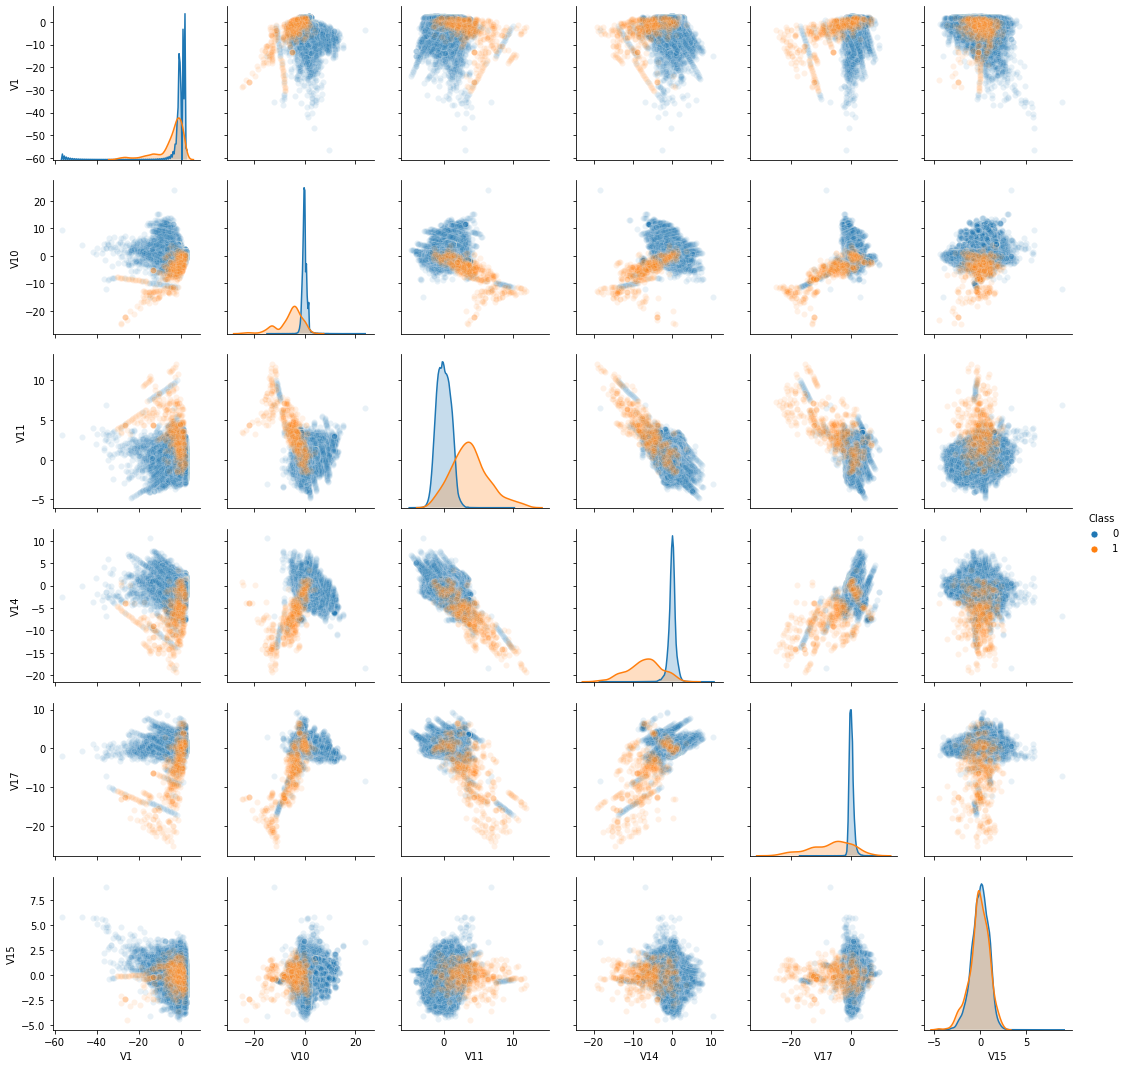

In [26]:
g = sns.pairplot(df, vars = ["V1", "V10", "V11", "V14", "V17", "V15"], hue='Class',
             plot_kws={"alpha": 0.1});


for lh in g._legend.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [50]

In [1]:
rus = RandomUnderSampler(random_state=0)
pca_cols = df.iloc[:, 1:28]
X_resampled, y_resampled = rus.fit_resample(pca_cols, df['Class'])
print(sorted(Counter(y_resampled).items()))

NameError: ignored